In [8]:
import keras
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.decomposition import PCA
import tensorflow as tf
tf.debugging.set_log_device_placement(False) 
import warnings
warnings.filterwarnings('ignore')

In [9]:
tf.random.set_seed(14) 

In [10]:
forest=pd.read_csv('/content/forestfires.csv')
forest.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,...,monthfeb,monthjan,monthjul,monthjun,monthmar,monthmay,monthnov,monthoct,monthsep,size_category
0,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,...,0,0,0,0,1,0,0,0,0,small
1,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,...,0,0,0,0,0,0,0,1,0,small
2,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,...,0,0,0,0,0,0,0,1,0,small
3,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,...,0,0,0,0,1,0,0,0,0,small
4,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,...,0,0,0,0,1,0,0,0,0,small


In [11]:
df = forest.copy()
df.drop(df.columns[11:30],axis=1,inplace = True)

In [12]:
df.shape

(517, 12)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [14]:
df.columns

Index(['month', 'day', 'FFMC', 'DMC', 'DC', 'ISI', 'temp', 'RH', 'wind',
       'rain', 'area', 'size_category'],
      dtype='object')

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   month          517 non-null    object 
 1   day            517 non-null    object 
 2   FFMC           517 non-null    float64
 3   DMC            517 non-null    float64
 4   DC             517 non-null    float64
 5   ISI            517 non-null    float64
 6   temp           517 non-null    float64
 7   RH             517 non-null    int64  
 8   wind           517 non-null    float64
 9   rain           517 non-null    float64
 10  area           517 non-null    float64
 11  size_category  517 non-null    object 
dtypes: float64(8), int64(1), object(3)
memory usage: 48.6+ KB


In [16]:
df.isnull().sum()

month            0
day              0
FFMC             0
DMC              0
DC               0
ISI              0
temp             0
RH               0
wind             0
rain             0
area             0
size_category    0
dtype: int64

Feature Analysis

In [17]:
df.month.value_counts()

aug    184
sep    172
mar     54
jul     32
feb     20
jun     17
oct     15
apr      9
dec      9
jan      2
may      2
nov      1
Name: month, dtype: int64

In [18]:
df.size_category.value_counts() 

small    378
large    139
Name: size_category, dtype: int64

label encoding

In [19]:
from sklearn import preprocessing
label_encoder = preprocessing.LabelEncoder()
df.month= label_encoder.fit_transform(df.month) 
df.day= label_encoder.fit_transform(df.day) 
df.size_category= label_encoder.fit_transform(df.size_category) 
df.head()

,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area,size_category
0,7,0,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0,1
1,10,5,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0,1
2,10,2,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0,1
3,7,0,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0,1
4,7,3,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0,1


Removing Bias in the Dataset

In [20]:
from imblearn.combine import SMOTETomek
from collections import Counter

resamp = df.copy()

#Define dataset
a = resamp.iloc[:,:-1]
b = resamp.iloc[:,-1]

#Count before
print(Counter(b))

smt = SMOTETomek(sampling_strategy = 'auto')
a, b = smt.fit_resample(a, b)

#Count after
print(Counter(b)) #removed bias in dataset

Counter({1: 378, 0: 139})
Counter({1: 371, 0: 371})


In [21]:
X = a
Y = b
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.3)

Neural Network Modelling

In [22]:
# create model
model = Sequential()
model.add(Dense(14, input_dim=11, kernel_initializer='uniform', activation='relu'))
model.add(Dense(12,kernel_initializer='uniform', activation='relu'))
model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
# Fit the model
hist = model.fit(X_train, y_train, validation_split=0.33, epochs=50, batch_size=10)

Epoch 1/50
35/35 [==============================] - 2s 20ms/step - loss: 0.6905 - accuracy: 0.5447 - val_loss: 0.6894 - val_accuracy: 0.5465
Epoch 2/50
35/35 [==============================] - 0s 4ms/step - loss: 0.6788 - accuracy: 0.6369 - val_loss: 0.6768 - val_accuracy: 0.5814
Epoch 3/50
35/35 [==============================] - 0s 5ms/step - loss: 0.6453 - accuracy: 0.6888 - val_loss: 0.6630 - val_accuracy: 0.5872
Epoch 4/50
35/35 [==============================] - 0s 3ms/step - loss: 0.5869 - accuracy: 0.7320 - val_loss: 0.5491 - val_accuracy: 0.8198
Epoch 5/50
35/35 [==============================] - 0s 3ms/step - loss: 0.5196 - accuracy: 0.7378 - val_loss: 0.5217 - val_accuracy: 0.7209
Epoch 6/50
35/35 [==============================] - 0s 5ms/step - loss: 0.4559 - accuracy: 0.7983 - val_loss: 0.4495 - val_accuracy: 0.8663
Epoch 7/50
35/35 [==============================] - 0s 5ms/step - loss: 0.4104 - accuracy: 0.8012 - val_loss: 0.5767 - val_accuracy: 0.6686
Epoch 8/50
35/35 [=

Model Evaluation

In [23]:
test_loss, test_acc = model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 2ms/step - loss: 0.0237 - accuracy: 0.9910


In [24]:
print(hist.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [25]:
hist_df = pd.DataFrame(hist.history)
hist_df["epoch"]=hist.epoch
hist_df.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.028677,0.985591,0.034335,0.982558,45
46,0.027814,0.988473,0.033064,0.982558,46
47,0.022872,0.994236,0.036960,0.970930,47
48,0.024258,0.991354,0.032492,0.982558,48
49,0.023099,0.991354,0.031630,0.982558,49


Visualize Training History

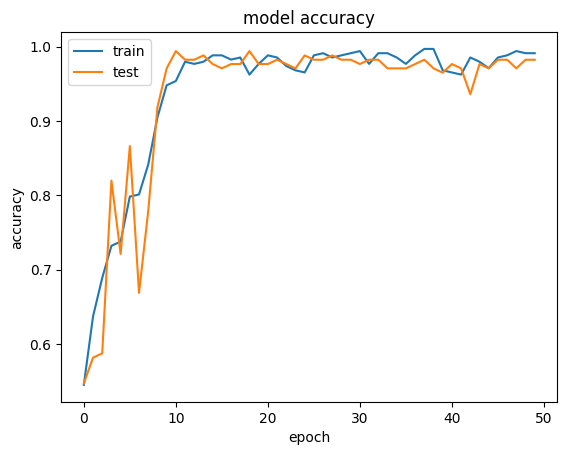

In [26]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

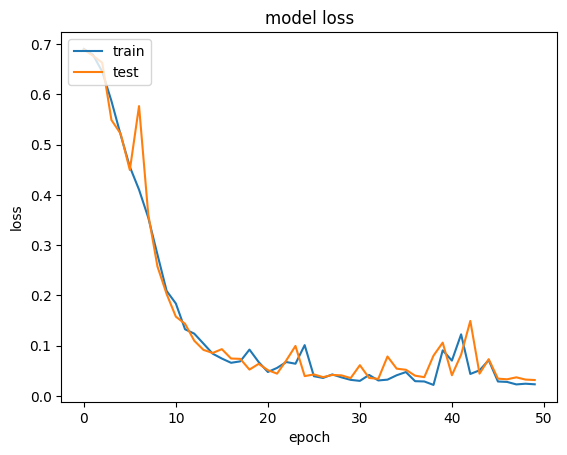

In [27]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

Tuning of Hyperparameters :- Batch Size and Epochs

In [28]:
from sklearn.model_selection import GridSearchCV, KFold
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from keras.optimizers import Adam

In [29]:
def create_model():
    model = Sequential()
    model.add(Dense(12, input_dim=8, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(8, kernel_initializer='uniform', activation='relu'))
    model.add(Dense(1, kernel_initializer='uniform', activation='sigmoid'))
    
    adam=Adam(lr=0.01)
    model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

In [30]:
from sklearn.preprocessing import StandardScaler
a = StandardScaler()
a.fit(X)
X_standardized = a.transform(X)

Tuning of Hyperparameters:- Learning rate and Drop out rate

In [31]:
from keras.layers import Dropout

In [32]:
def create_model2(learning_rate,dropout_rate):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(12,input_dim = 14,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1,kernel_initializer='uniform',activation = 'sigmoid'))
    
    adam = Adam(lr = learning_rate)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [33]:
model2 = KerasClassifier(build_fn = create_model2,verbose = 0,batch_size = 20,epochs = 50)
# Define the grid search parameters
learning_rate = [0.001,0.01,0.1]
dropout_rate = [0.0,0.1,0.2]

In [34]:
# Make a dictionary of the grid search parameters
param_grids2 = dict(learning_rate = learning_rate,dropout_rate = dropout_rate)
# Build and fit the GridSearchCV
grid2 = GridSearchCV(estimator = model2,param_grid = param_grids2,cv = KFold(),verbose = 10)
grid_result2 = grid2.fit(X_standardized,Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 1/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.993 total time=   6.0s
[CV 2/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 2/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.987 total time=  12.4s
[CV 3/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 3/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.946 total time=   3.4s
[CV 4/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 4/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=0.986 total time=   6.0s
[CV 5/5; 1/9] START dropout_rate=0.0, learning_rate=0.001.......................
[CV 5/5; 1/9] END dropout_rate=0.0, learning_rate=0.001;, score=1.000 total time=   3.4s
[CV 1/5; 2/9] START dropout_rate=0.0, learning_rate=0.01........................
[CV 1/5; 

In [35]:
print('Best : {}, using {}'.format(grid_result2.best_score_,grid_result2.best_params_))
means2 = grid_result2.cv_results_['mean_test_score']
stds2 = grid_result2.cv_results_['std_test_score']
params2 = grid_result2.cv_results_['params']
for mean, stdev, param in zip(means2, stds2, params2):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9905496120452881, using {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9824596285820008,0.018928029072100824 with: {'dropout_rate': 0.0, 'learning_rate': 0.001}
0.9838382005691528,0.011762252145616528 with: {'dropout_rate': 0.0, 'learning_rate': 0.01}
0.9770905137062073,0.025793375205892335 with: {'dropout_rate': 0.0, 'learning_rate': 0.1}
0.9878650426864624,0.013085100694680257 with: {'dropout_rate': 0.1, 'learning_rate': 0.001}
0.9798022866249084,0.01752923501786092 with: {'dropout_rate': 0.1, 'learning_rate': 0.01}
0.9435062646865845,0.045025302491383416 with: {'dropout_rate': 0.1, 'learning_rate': 0.1}
0.9905496120452881,0.01011502041986296 with: {'dropout_rate': 0.2, 'learning_rate': 0.001}
0.9797932147979737,0.022127916978460612 with: {'dropout_rate': 0.2, 'learning_rate': 0.01}
0.7689733266830444,0.3849250979720305 with: {'dropout_rate': 0.2, 'learning_rate': 0.1}


Tuning of Hyperparameters:- Activation Function and Kernel Initialize

In [36]:
def create_model3(activation_function,init):
    model = Sequential()
    model.add(Dense(14,input_dim = 11,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(12,input_dim = 14,kernel_initializer = init,activation = activation_function))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [37]:
# Create the model

model3 = KerasClassifier(build_fn = create_model3,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters
activation_function = ['softmax','relu','tanh','linear']
init = ['uniform','normal','zero']

# Make a dictionary of the grid search parameters
param_grids3 = dict(activation_function = activation_function,init = init)

# Build and fit the GridSearchCV

grid3 = GridSearchCV(estimator = model3,param_grid = param_grids3,cv = KFold(),verbose = 10)
grid_result3 = grid3.fit(X_standardized,Y)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 1/5; 1/12] END activation_function=softmax, init=uniform;, score=0.007 total time=   6.1s
[CV 2/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 2/5; 1/12] END activation_function=softmax, init=uniform;, score=0.799 total time=   6.1s
[CV 3/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 3/5; 1/12] END activation_function=softmax, init=uniform;, score=0.453 total time=   6.7s
[CV 4/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 4/5; 1/12] END activation_function=softmax, init=uniform;, score=0.588 total time=   6.1s
[CV 5/5; 1/12] START activation_function=softmax, init=uniform..................
[CV 5/5; 1/12] END activation_function=softmax, init=uniform;, score=0.149 total time=   6.1s
[CV 1/5; 2/12] START activation_function=softmax, init=normal...

In [38]:
print('Best : {}, using {}'.format(grid_result3.best_score_,grid_result3.best_params_))
means3 = grid_result3.cv_results_['mean_test_score']
stds3 = grid_result3.cv_results_['std_test_score']
params3 = grid_result3.cv_results_['params']
for mean, stdev, param in zip(means3, stds3, params3):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9865227699279785, using {'activation_function': 'relu', 'init': 'uniform'}
0.39891165811568496,0.28804030551074317 with: {'activation_function': 'softmax', 'init': 'uniform'}
0.40159622579813004,0.27244210876372327 with: {'activation_function': 'softmax', 'init': 'normal'}
0.35568655729293824,0.31315262911140895 with: {'activation_function': 'softmax', 'init': 'zero'}
0.9865227699279785,0.012046439812994114 with: {'activation_function': 'relu', 'init': 'uniform'}
0.9824687123298645,0.013914865765694109 with: {'activation_function': 'relu', 'init': 'normal'}
0.20339198112487794,0.1855601217500651 with: {'activation_function': 'relu', 'init': 'zero'}
0.9865136981010437,0.012805813297188261 with: {'activation_function': 'tanh', 'init': 'uniform'}
0.9865136981010437,0.012805813297188261 with: {'activation_function': 'tanh', 'init': 'normal'}
0.20339198112487794,0.1855601217500651 with: {'activation_function': 'tanh', 'init': 'zero'}
0.9865136861801147,0.012071752597660131 with: {'

Tuning of Hyperparameter :-Number of Neurons in activation layer

In [39]:
def create_model4(neuron1,neuron2):
    model = Sequential()
    model.add(Dense(neuron1,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(neuron2,input_dim = neuron1,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [40]:
# Create the model

model4 = KerasClassifier(build_fn = create_model4,verbose = 0,batch_size = 20,epochs = 50)

# Define the grid search parameters

neuron1 = [4,8,14]
neuron2 = [4,8,12]

# Make a dictionary of the grid search parameters

param_grids4 = dict(neuron1 = neuron1,neuron2 = neuron2)

# Build and fit the GridSearchCV

grid4 = GridSearchCV(estimator = model4,param_grid = param_grids4,cv = KFold(),verbose = 10)
grid_result4 = grid4.fit(X_standardized,Y)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 1/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.993 total time=   3.5s
[CV 2/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 2/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.966 total time=   6.3s
[CV 3/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 3/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.946 total time=   6.1s
[CV 4/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 4/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.980 total time=   4.1s
[CV 5/5; 1/9] START neuron1=4, neuron2=4........................................
[CV 5/5; 1/9] END .........neuron1=4, neuron2=4;, score=0.980 total time=   3.3s
[CV 1/5; 2/9] START neuron1=4, neuron2=8........................................
[CV 1/5; 2/9] END .........neuron1=4, neuron2=8;,

In [41]:
print('Best : {}, using {}'.format(grid_result4.best_score_,grid_result4.best_params_))
means4 = grid_result4.cv_results_['mean_test_score']
stds4 = grid_result4.cv_results_['std_test_score']
params4 = grid_result4.cv_results_['params']
for mean, stdev, param in zip(means4, stds4, params4):
  print('{},{} with: {}'.format(mean, stdev, param))

Best : 0.9851714134216308, using {'neuron1': 14, 'neuron2': 8}
0.9730273723602295,0.015981983392911635 with: {'neuron1': 4, 'neuron2': 4}
0.964937424659729,0.021084739950781115 with: {'neuron1': 4, 'neuron2': 8}
0.9797659993171692,0.014155971571481607 with: {'neuron1': 4, 'neuron2': 12}
0.9757391691207886,0.019320612643880852 with: {'neuron1': 8, 'neuron2': 4}
0.9838200569152832,0.010942881498070342 with: {'neuron1': 8, 'neuron2': 8}
0.9851623415946961,0.01161223097410612 with: {'neuron1': 8, 'neuron2': 12}
0.9811173558235169,0.02021076623291999 with: {'neuron1': 14, 'neuron2': 4}
0.9851714134216308,0.011618556450909843 with: {'neuron1': 14, 'neuron2': 8}
0.9838200688362122,0.013911341240098431 with: {'neuron1': 14, 'neuron2': 12}


# Hyperparameters all at once

The hyperparameter optimization was carried out by taking 2 hyperparameters at once. We may have missed the best values. The performance can be further improved by finding the optimum values of hyperparameters all at once given by the code snippet below.

In [42]:
def create_model_fnl():
    model = Sequential()
    model.add(Dense(4,input_dim = 11,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(4,input_dim = 4,kernel_initializer = 'uniform',activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1,activation = 'sigmoid'))
    
    adam = Adam(lr = 0.001) #sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
    model.compile(loss = 'binary_crossentropy',optimizer = adam,metrics = ['accuracy'])
    return model

In [43]:
# Create the model
model_fnl = KerasClassifier(build_fn = create_model_fnl,verbose = 0,batch_size = 20,epochs = 50)
#Making training and Testing Data
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_standardized,Y, test_size = 0.3)
# Fitting the model
hist2 = model_fnl.fit(X_train_1,y_train_1)

In [52]:
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
def report_model(model):
    model_preds = model.predict(X_test_1)
    print(confusion_matrix(y_test_1,model_preds))
    print(classification_report(y_test_1,model_preds))
report_model(model_fnl)

7/7 [==============================] - 0s 3ms/step
[[ 92  10]
 [  0 121]]
              precision    recall  f1-score   support

           0       1.00      0.90      0.95       102
           1       0.92      1.00      0.96       121

    accuracy                           0.96       223
   macro avg       0.96      0.95      0.95       223
weighted avg       0.96      0.96      0.95       223

